<font size="5"> This python notebook focuses on plotting cumulative area distribution for a given experiment.</font><br> The fragment area of the experiment has been computed <i>a priori</i> and stored in a <<i>test_name</i>>_area.mat file.

In [2]:
from scipy.optimize import curve_fit
import pickle
import numpy as np
import matplotlib.pyplot as plt

Custom mplstyle file for plot formatting

In [5]:
mplstyle_file = r'C:\Users\vinee\OneDrive\Documents\vscode\stressed network model\article_preprint.mplstyle'
plt.style.use(f'{mplstyle_file}')

Read data from .txt file

In [143]:
filename = 'test8_area'
data_dir_path = r'C:\Users\vinee\OneDrive\Documents\MATLAB\experiment_data\area'
with open(data_dir_path + f'/{filename}.txt', 'r') as f:
    size = f.readlines()

size = [float(s.strip()) for s in size]
print(f'Total fragments: {len(size)}')

Total fragments: 266


Setting the minimum cut-off area below that will not be considered. Below is the list of the cut-off used:<br>
- $A_{\rm{cut-off}} = 2$ $\text{mm}^2$ for our impact experiments<br> 
- $A_{\rm{cut-off}} = 0.1$ $\text{mm}^2$ for Tandon and Glass (2015)<br>
- $A_{\rm{cut-off}} = 2.86$ $\text{mm}^2$ for Zijlstra and Burggraaf (1969)<br>

In [144]:
cut_off_area = 2
size_cut_off = [s for s in size if s >= cut_off_area]

max_size = max(size_cut_off)
min_size = min(size_cut_off)
print(f'Min size: {min_size}, Max size: {max_size}')
print(f'Total fragments above cut-off: {len(size_cut_off)}')

Min size: 2.18175932242272, Max size: 67.8201158775483
Total fragments above cut-off: 138


Check area distribution (optional) so see how data is distributed

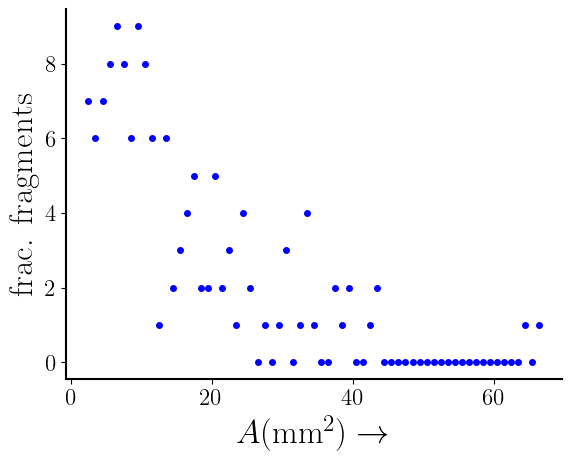

In [145]:
bins = np.arange(cut_off_area, max(size_cut_off), 1)
y,x = np.histogram(size_cut_off, bins=bins)
x = (x[:-1] + x[1:]) / 2  # bin
fig, ax = plt.subplots()

# plot as a histogram
# counts, bins, patches = ax.hist(size, bins=bins, edgecolor='black', weights=np.ones(len(size)) / len(size))

# plot as a curve
ax.plot(x, y, marker='o', linestyle='None', color='blue', label='data', markersize=4)

ax.set_xlabel(r'$A (\rm{mm}^2)\rightarrow$')
ax.set_ylabel(r'frac. fragments')

# if required, plot in log scale
# ax.set_yscale('log')

# ax.set_xlim([0, 1])
# fig.savefig(data_dir_path+ '/test3_power_2cut_area5.png', dpi=300, bbox_inches='tight')
plt.show()

Remove largest fragment area, if required. Usually, it is removed if there is single large fragment so as it does not affect fitting. We can also remove fragment area above certain upper limit. This is accomplished by eyeballing.


In [146]:
# if you want to remove the largest area
# size_range = [s for s in size_cut_off if s!=max_size]
# upper_limit = max_size

# if you want to put upper limit
# upper_limit = 60
# size_range = [s for s in size_cut_off if s <= upper_limit]

# if no upper limit, just use the original size
size_range = size_cut_off
upper_limit = 0

max_size = max(size_range)
min_size = min(size_range)
print(f'amin: {min_size}, amax: {max_size}')
print(f'Total fragments: {len(size_range)}')

amin: 2.18175932242272, amax: 67.8201158775483
Total fragments: 138


Finding cumulative fragment area. <span style="color:rgb(255, 139, 30);"> Make sure to properly choose step size of distribution. </span>

In [147]:
# find cumulative area distribution
cum_area = np.arange(min_size, max_size, 1)
cum_count = np.zeros_like(cum_area)
for i in range(len(cum_area)):
    cum_count[i] = len([s for s in size_range if s >= cum_area[i]])

total_count = cum_count[0]
print(total_count)

138.0


Define exponential fitting function

In [6]:
# fit exponential function to the data
def exp_fit(x, a, b):
    return a*np.exp(b*x)

Performing curve fit operation on the experimental data

In [148]:
p, p_cov = curve_fit(exp_fit, cum_area, cum_count/total_count, p0=[1, -0.1])
print('Fitted parameters: a = ', p[0], ', b = ', p[1])
print('Covariance of parameters:', np.sqrt(np.diag(p_cov)))

# compute R^2
y_predicted = exp_fit(cum_area, *p)
ss_tot = np.sum((cum_area - np.mean(cum_area))**2)
ss_res = np.sum((cum_count/total_count - y_predicted)**2)
r_squared = 1 - (ss_res / ss_tot)
print(f'R^2: {r_squared}')

Fitted parameters: a =  1.2104539724606138 , b =  -0.07510238721333884
Covariance of parameters: [0.00769314 0.00059598]
R^2: 0.9999996837276451


Plotting result

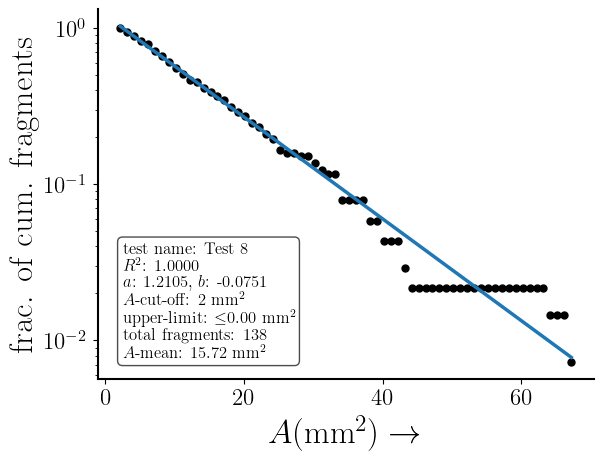

In [149]:
save_path = r'C:\Users\vinee\OneDrive\Documents\MATLAB\experiment_data\area\results'

fig, ax = plt.subplots()
ax.plot(cum_area, cum_count/total_count, color='black', linestyle = 'none', markersize = 5, marker = 'o')
ax.plot(cum_area, exp_fit(cum_area, p[0], p[1]), color='tab:blue')
ax.set_xlabel(r'$A (\rm{mm}^2)\rightarrow$')
ax.set_ylabel(r'frac. of cum. fragments')

# if requried semilog scale
ax.set_yscale('log')

ax.text(
    0.05, 0.05,
    r"test name: Test 8"
    + "\n"
    + r"$R^2$: {:.4f}".format(r_squared)
    + "\n"
    + r"$a$: {:.4f}, $b$: {:.4f}".format(p[0], p[1])
    + "\n"
    + r"$A$-cut-off: {} mm$^2$".format(cut_off_area)
    + "\n"
    + r"upper-limit: $\leq ${:.2f} mm$^2$".format(upper_limit)
    + "\n"
    + r"total fragments: {}".format(int(total_count))
    + "\n"
    + r"$A$-mean: {:.2f} mm$^2$".format(np.mean(size_range)),
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment='bottom',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)

fig.savefig(save_path+ f'/{filename}.png', dpi=300, bbox_inches='tight')
plt.show()

Save the fit data if needed

In [150]:
save_path = r'C:\Users\vinee\OneDrive\Documents\MATLAB\experiment_data\area\results'

with open(save_path + f'/{filename}_cum_area', 'wb') as f:
    pickle.dump([cum_area, cum_count, p, p_cov, size_range], f)

<font size="5"> <span style="color:rgb(255, 139, 30);"> Collate all experimental data into single plot </span>

First, we will read our impact experimental data. 

Fit parameters for v = 34: [ 1.10352301 -0.07691184], [[ 9.52864221e-05 -6.63669464e-06]
 [-6.63669464e-06  1.00029956e-06]]
Fit parameters for v = 20: [ 1.12315763 -0.066825  ], [[ 1.26244765e-04 -7.53013953e-06]
 [-7.53013953e-06  9.59519090e-07]]


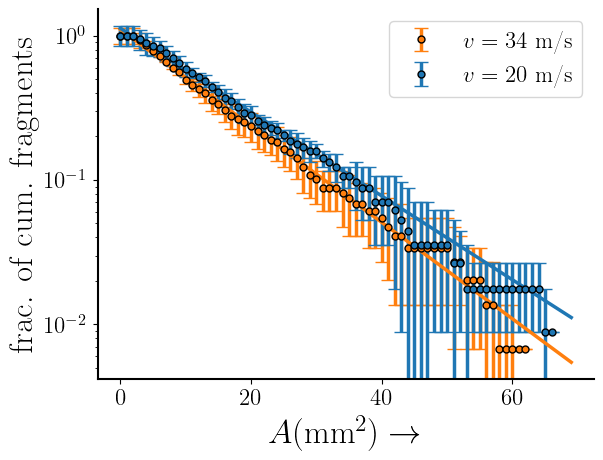

In [155]:
read_path = r'C:\Users\vinee\OneDrive\Documents\MATLAB\experiment_data\area\results'

# For v = 34
filename = 'test1_area_cum_area'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area1, cum_count1, p1, p_conv1, area1 = pickle.load(f)

filename = 'test2_area_cum_area'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area2, cum_count2, p2, p_conv2, area2 = pickle.load(f)

filename = 'test3_area_cum_area'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area3, cum_count3, p3, p_conv3, area3 = pickle.load(f)

# For v = 20
filename = 'test6_area_cum_area'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area6, cum_count6, p6, p_conv6, area6 = pickle.load(f)

filename = 'test7_area_cum_area'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area7, cum_count7, p7, p_conv7, area7 = pickle.load(f)

filename = 'test8_area_cum_area'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area8, cum_count8, p8, p_conv8, area8 = pickle.load(f)

# find average of (1,2,3)
min_area = min([min(area1), min(area2), min(area3)])
max_area = max([max(area1), max(area2), max(area3)])

cum_area123 = np.arange(0, 70, 1)
cum_count123 = np.zeros_like(cum_area123)
cum_count123_std = np.zeros_like(cum_area123)
for i in range(len(cum_area123)):
    count1 = len([s for s in area1 if s >= cum_area123[i]])
    count2 = len([s for s in area2 if s >= cum_area123[i]])
    count3 = len([s for s in area3 if s >= cum_area123[i]])
    cum_count123[i] = (count1 + count2 + count3)/3
    cum_count123_std[i] = np.std([count1, count2, count3], axis=0)

# find average of (6,7,8)
min_area = min([min(area6), min(area7), min(area8)])
max_area = max([max(area6), max(area7), max(area8)])
cum_area678 = np.arange(0, 70, 1)
cum_count678 = np.zeros_like(cum_area678)
cum_count678_std = np.zeros_like(cum_area678)
for i in range(len(cum_area678)):
    count6 = len([s for s in area6 if s >= cum_area678[i]])
    count7 = len([s for s in area7 if s >= cum_area678[i]])
    count8 = len([s for s in area8 if s >= cum_area678[i]])
    cum_count678[i] = (count6 + count7 + count8)/3
    cum_count678_std[i] = np.std([count6, count7, count8], axis=0)

p1, p_conv1 = curve_fit(exp_fit, cum_area123, cum_count123/cum_count123[0], p0=[1, -0.1])
print(f'Fit parameters for v = 34: {p1}, {p_conv1}')

p2, p_conv2 = curve_fit(exp_fit, cum_area678, cum_count678/cum_count678[0], p0=[1, -0.1])
print(f'Fit parameters for v = 20: {p2}, {p_conv2}')

# We can separate plot and check
fig, ax = plt.subplots()
# Uncomment for shaded band for error bars
# ax.plot(cum_area678, cum_count678/cum_count678[0], color='tab:blue', linestyle = 'none', markersize = 5, marker = 'o', label=r'$v = 20$ m/s', markeredgecolor='black')
# ax.plot(cum_area123, cum_count123/cum_count123[0], color ='tab:orange', linestyle = 'none', markersize = 5, marker = 'o', label=r'$v = 34$ m/s', markeredgecolor='black')
# ax.fill_between(cum_area123, (cum_count123 - cum_count123_std)/cum_count123[0], (cum_count123 + cum_count123_std)/cum_count123[0], color='tab:orange', alpha=0.3)
# ax.fill_between(cum_area678, (cum_count678 - cum_count678_std)/cum_count678[0], (cum_count678 + cum_count678_std)/cum_count678[0], color='tab:blue', alpha=0.3)

# Plot with error bars
ax.errorbar(cum_area123, cum_count123/cum_count123[0], yerr=cum_count123_std/cum_count123[0], ecolor='tab:orange', capsize=5,
            linestyle='none', marker='o', markersize=5, color='tab:orange', label=r'$v = 34$ m/s', markeredgecolor='black')
ax.errorbar(cum_area678, cum_count678/cum_count678[0], yerr=cum_count678_std/cum_count678[0], ecolor='tab:blue', capsize=5,
               linestyle='none', marker='o', markersize=5, color='tab:blue', label=r'$v = 20$ m/s', markeredgecolor='black')
ax.plot(cum_area123, exp_fit(cum_area123, p1[0], p1[1]), color='tab:orange')
ax.plot(cum_area678, exp_fit(cum_area678, p2[0], p2[1]), color='tab:blue')

ax.legend()

# Uncomment for semilog yscale
ax.set_yscale('log')

ax.set_xlabel(r'$A (\rm{mm}^2)\rightarrow$')
ax.set_ylabel(r'frac. of cum. fragments')
# fig.savefig(data_dir_path+ '/exp_cum_area_avg.png', dpi=300, bbox_inches='tight')
plt.show()

Second, we load literature data

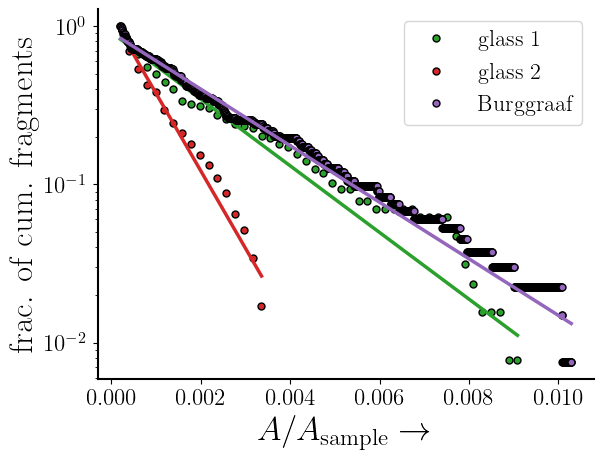

In [162]:
read_path = r'C:\Users\vinee\OneDrive\Documents\MATLAB\experiment_data\area\results'

# literature data
filename = 'glass1_area_cum_area'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_glass1, cum_count_glass1, p_glass1, p_conv_glass1, area_glass1 = pickle.load(f)

filename = 'glass2_area_cum_area'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_glass2, cum_count_glass2, p_glass2, p_conv_glass2, area_glass2 = pickle.load(f)

filename = 'burggraaf_area_cum_area'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_burggraaf, cum_count_burggraaf, p_burggraaf, p_conv_burggraaf, area_burggraaf = pickle.load(f)

# We can separate plot and check
fig, ax = plt.subplots()
A_glass = (np.pi/4)*25.4**2
# plot the data for glass 1
ax.plot(cum_area_glass1/A_glass, cum_count_glass1/cum_count_glass1[0], color='tab:green', linestyle = 'none', markersize = 5, marker = 'o', label=r'glass 1', markeredgecolor='black')
ax.plot(cum_area_glass1/A_glass, exp_fit(cum_area_glass1, p_glass1[0], p_glass1[1]), color='tab:green')
# plot the data for glass 2
ax.plot(cum_area_glass2/A_glass, cum_count_glass2/cum_count_glass2[0], color='tab:red', linestyle = 'none', markersize = 5, marker = 'o', label=r'glass 2', markeredgecolor='black')
ax.plot(cum_area_glass2/A_glass, exp_fit(cum_area_glass2, p_glass2[0], p_glass2[1]), color='tab:red')

A_burggraaf = (np.pi/4)*135**2
# plot the data for burggraaf
ax.plot(cum_area_burggraaf/A_burggraaf, cum_count_burggraaf/cum_count_burggraaf[0], color='tab:purple', linestyle = 'none', markersize = 5, marker = 'o', label=r'Burggraaf', markeredgecolor='black')
ax.plot(cum_area_burggraaf/A_burggraaf, exp_fit(cum_area_burggraaf, p_burggraaf[0], p_burggraaf[1]), color='tab:purple')

ax.legend()

# Uncomment for semilog yscale
ax.set_yscale('log')

ax.set_xlabel(r'$A/A_{\rm{sample}}\rightarrow$')
ax.set_ylabel(r'frac. of cum. fragments')
# fig.savefig(r'C:\Users\vinee\OneDrive\Documents\MATLAB'+ '/exp_cum_area_literature.png', dpi=300, bbox_inches='tight')
plt.show()


NameError: name 'cum_area123' is not defined

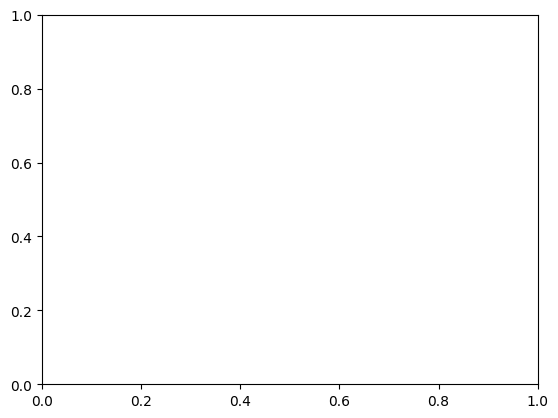

In [4]:
save_dir_path = r'C:\Users\vinee\OneDrive\Documents\MATLAB\experiment_data\area\results\collated'

fig, ax = plt.subplots()

ms = 8
mec = 'black'

# our experiment data
A0 = 60*60
# ax.errorbar(cum_area123/A0, cum_count123/cum_count123[0], yerr=cum_count123_std/cum_count123[0], ecolor='tab:orange', capsize=5,
#             linestyle='none', marker='*', markersize=ms, color='tab:orange', label=r'$v = 34$ m/s', mec=mec)
# ax.errorbar(cum_area678/A0, cum_count678/cum_count678[0], yerr=cum_count678_std/cum_count678[0], ecolor='tab:orange', capsize=5,
#             linestyle='none', marker='^', markersize=ms, color='tab:orange', label=r'$v = 20$ m/s', mec=mec)

ax.plot(cum_area123/A0, exp_fit(cum_area123, p1[0], p1[1]), color='tab:orange', linestyle='solid')
ax.plot(cum_area678/A0, exp_fit(cum_area678, p2[0], p2[1]), color='tab:blue', linestyle='dashed')
ax.plot(cum_area678/A0, cum_count678/cum_count678[0], color='tab:blue', linestyle='none',
         markersize=ms, marker='^', mec=mec, label = r'$v = 20$ m/s')
ax.plot(cum_area123/A0, cum_count123/cum_count123[0], color='tab:orange', linestyle='none',
         markersize=ms, marker='*', mec=mec, label =r'$v = 34$ m/s')


# literature data
A_glass = (np.pi/4)*25.4**2
# plot the data for glass 1
ax.plot(cum_area_glass1/A_glass, exp_fit(cum_area_glass1, p_glass1[0], p_glass1[1]), color='tab:green')
ax.plot(cum_area_glass1/A_glass, cum_count_glass1/cum_count_glass1[0], color='tab:green', linestyle='none',
         markersize=ms, marker='X', label=r'glass 1', mec=mec)

# plot the data for glass 2
ax.plot(cum_area_glass2/A_glass, exp_fit(cum_area_glass2, p_glass2[0], p_glass2[1]), color='tab:green', linestyle='dashed')
ax.plot(cum_area_glass2/A_glass, cum_count_glass2/cum_count_glass2[0], color='tab:green', linestyle='none', 
        markersize=ms, marker='P', label=r'glass 2', mec=mec)


A_burggraaf = (np.pi/4)*135**2
# plot the data for burggraaf
ax.plot(cum_area_burggraaf/A_burggraaf, exp_fit(cum_area_burggraaf, p_burggraaf[0], p_burggraaf[1]), color='tab:green',
         linestyle='dotted')
ax.plot(cum_area_burggraaf/A_burggraaf, cum_count_burggraaf/cum_count_burggraaf[0], color='tab:green', linestyle='none',
         markersize=ms, marker='h', label=r'Burggraaf', mec=mec)


ax.set_xlabel(r'$A/A_{\rm{sample}}\rightarrow$')
ax.set_ylabel(r'frac. of cum. fragments')
# ax.set_ylim(bottom=1e-3)
ax.set_yscale('log')    # Change to log scale for better visibility of small values

ax.legend()
# fig.savefig(save_dir_path+ '/experiment_literature.png', dpi=300, bbox_inches='tight')
plt.show()

<font size="5"> <span style="color:rgb(255, 139, 30);"> Plotting mean area and exponential coefficient </span>

Slope of the fit line: 1.0437735743584324


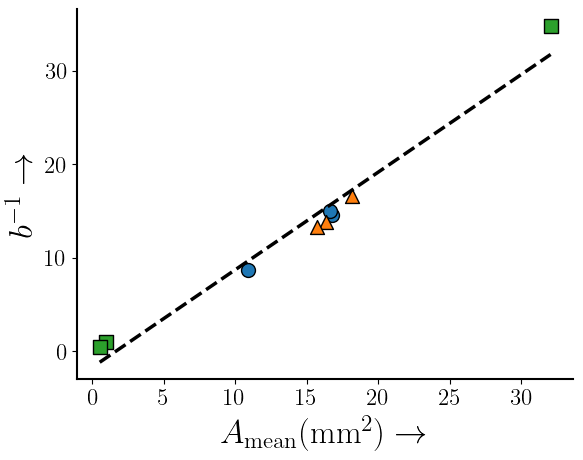

In [10]:
read_path = r'C:\Users\vinee\OneDrive\Documents\MATLAB\experiment_data\area\results'

# For v = 34
filename = 'test1_area_cum_area'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area1, cum_count1, p1, p_conv1, area1 = pickle.load(f)

filename = 'test2_area_cum_area'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area2, cum_count2, p2, p_conv2, area2 = pickle.load(f)

filename = 'test3_area_cum_area'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area3, cum_count3, p3, p_conv3, area3 = pickle.load(f)

# For v = 20
filename = 'test6_area_cum_area'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area6, cum_count6, p6, p_conv6, area6 = pickle.load(f)

filename = 'test7_area_cum_area'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area7, cum_count7, p7, p_conv7, area7 = pickle.load(f)

filename = 'test8_area_cum_area'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area8, cum_count8, p8, p_conv8, area8 = pickle.load(f)

# literature data
filename = 'glass1_area_cum_area'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_glass1, cum_count_glass1, p_glass1, p_conv_glass1, area_glass1 = pickle.load(f)

filename = 'glass2_area_cum_area'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_glass2, cum_count_glass2, p_glass2, p_conv_glass2, area_glass2 = pickle.load(f)

filename = 'burggraaf_area_cum_area'
with open(read_path + f'/{filename}', 'rb') as f:
    cum_area_burggraaf, cum_count_burggraaf, p_burggraaf, p_conv_burggraaf, area_burggraaf = pickle.load(f)

A_mean = np.array([
    np.mean(area1),
    np.mean(area2),
    np.mean(area3),
    np.mean(area6),
    np.mean(area7),
    np.mean(area8),
    np.mean(area_glass1),
    np.mean(area_glass2),
    np.mean(area_burggraaf)])

b = np.array([
    p1[1],
    p2[1],
    p3[1],
    p6[1],
    p7[1],
    p8[1],
    p_glass1[1],
    p_glass2[1],
    p_burggraaf[1]])

b = np.abs(1/b)  # Inverse of b for plotting

# Create a scatter plot
fig, ax = plt.subplots()
ax.scatter(A_mean[:3], b[:3], color='tab:blue', marker='o', s=100, edgecolor='black')
ax.scatter(A_mean[3:6], b[3:6], color='tab:orange', marker='^', s=100, edgecolor='black')
ax.scatter(A_mean[6:], b[6:], color='tab:green', marker='s', s=100, edgecolor='black')

# Add a trend line
p_trend, _ = np.polyfit(A_mean, b, 1, cov=True)
print(f"Slope of the fit line: {p_trend[0]}")

x_fit = np.linspace(min(A_mean), max(A_mean), 100)
y_fit = np.polyval(p_trend, x_fit)
ax.plot(x_fit, y_fit, color='black', linestyle='--', label='Trend line')

ax.set_xlabel(r'$A_{\rm{mean}} (\rm{mm}^2)\rightarrow$')
ax.set_ylabel(r'$b^{-1} \rightarrow$')

# Save the figure
fig.savefig(save_dir_path + '/mean_area_vs_b.png', dpi=300, bbox_inches='tight')
plt.show()